In [1]:
#import packages
import numpy as np
import copy
import pandas
import os
import imp
import pickle
from scipy.interpolate import interp1d
import warnings
import time
import matplotlib.pyplot as plt
import inspect
import types
import math as mat
import seaborn as sns
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
import datetime
from matplotlib import animation
from IPython.display import HTML
from tempfile import NamedTemporaryFile
import matplotlib.backends.backend_pdf
from scipy import interpolate
from itertools import groupby
import re
import csv
import copy
from fnmatch import fnmatch
import json
import h5py  

sns.set()
sns.set_style()
%matplotlib inline

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [145]:
#functions

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def get_elapsed_time(my_list):
#for list of lists
    all_t_ellapsed = []
    for i in range(len(my_list)):
        t_ellapsed = my_list[i] - my_list[i][0]
        all_t_ellapsed.append(t_ellapsed)
    return all_t_ellapsed

def smallestSignedAngleBetween(x, y):
    a = math.atan2(math.sin(y-x), math.cos(y-x))
    return a

def get_smallestSignedAngleBetween(ax, y):
    yy=np.deg2rad(np.ones(len(ax))*y)
    axx = np.deg2rad(ax)
    
    array_smallestsignedangle = []
    for k in range(len(ax)):
        kk = smallestSignedAngleBetween(axx[k], yy[k])*-1
        kk = (np.rad2deg(kk))
        array_smallestsignedangle.append(kk)
    
    return array_smallestsignedangle

In [3]:
dataDir = '/Users/fponce/Documents/vdesert/temp'
pattern_vdesert_data = "*.hdf5"

datapaths = []
for path, subdirs, files in os.walk(dataDir):
    for name in files:
        if fnmatch(name, pattern_vdesert_data):
            datapaths.append(os.path.join(path, name))
            
print(datapaths[-1])
print(len(datapaths))

/Users/fponce/Documents/vdesert/temp/data_2019-08-23-15-33-17.hdf5
5


In [4]:
#panels 
# [[-180.0,  -90.0], 1] 
# [[ -90.0,    0.0], 2]
# [[   0.0,   90.0], 4]
# [[  90.0,  180.0], 3]

In [125]:
#check for keys
for i in range(len(datapaths)):
    f = h5py.File(datapaths[i], "r")
    datasetNames = [n for n in f.keys()]
print(datasetNames)

['alicat_tsstamp', 'alicat_tstamps', 'angle', 'autostep_action_running', 'autostep_action_started', 'autostep_action_stopped', 'current_trial_index', 'elapsed_time', 'flow_action_running', 'flow_action_started', 'flow_action_stopped', 'init_angle', 'ledpanels_panels_arg1', 'ledpanels_panels_arg2', 'ledpanels_panels_arg3', 'ledpanels_panels_arg4', 'ledpanels_panels_arg5', 'ledpanels_panels_arg6', 'ledpanels_panels_command', 'ledpanels_ros_tstamps', 'magnotether_angle', 'magnotether_frame', 'magnotether_ros_tstamps', 'magnotether_tstamps', 'motion_data_position', 'motion_data_ros_tstamps', 'motion_data_seq', 'motion_data_setpoint', 'motion_data_time', 'motion_data_tstamps', 'name', 'panels_action_running', 'panels_action_started', 'panels_action_stopped', 'ros_tstamps', 'seq', 'trial_e_time', 'tstamps']


In [6]:
#hdf5 -> np.arrays
all_ros_ts = []
all_ts = []
all_elapsed_time = []
all_trial_index = []
all_trial_elapsed_time = []
all_angle_for_autostep = []
all_init_angle = []
all_autostep_running = []
all_autostep_started = []
all_autostep_stopped = []
all_flow_running = []
all_flow_started = []
all_flow_stopped = []
all_panels_running = []
all_panels_started = []
all_panels_stopped = []

all_magnotether_angle = []
all_magnotether_ros_tstamps = []
all_magnotether_tstamps = []

all_motion_ros_tstamps = []
all_motion_tstamps = []
all_motion_setpoint = []
all_motion_position = []

all_ledpanels_ros_tstamps = []
all_ledpanels_command = []
all_ledpanels_1 = []
all_ledpanels_2 = []
all_ledpanels_3 = []
all_ledpanels_4 = []
all_ledpanels_5 = []
all_ledpanels_6 = []

for i in range(len(datapaths)):
    f = h5py.File(datapaths[i], "r")
    
    #virtual_desert topic
    ros_ts = np.asarray(f['ros_tstamps'])
    ts = np.asarray(f['tstamps'])
    elapsed_time = np.asarray(f['elapsed_time'])
    trial_index = np.asarray(f['current_trial_index'])
    trial_elapsed_time = np.asarray(f['trial_e_time'])
    angle_for_autostep = np.asarray(f['angle'])
    init_angle = np.asarray(f['init_angle'])
    
    #actions
    autostep_running = np.asarray(f['autostep_action_running'])
    autostep_started = np.asarray(f['autostep_action_started'])
    autostep_stopped = np.asarray(f['autostep_action_stopped'])
    
    flow_running = np.asarray(f['flow_action_running'])
    flow_started = np.asarray(f['flow_action_started'])
    flow_stopped = np.asarray(f['flow_action_stopped'])  
    
    panels_running = np.asarray(f['panels_action_running'])
    panels_started = np.asarray(f['panels_action_started'])
    panels_stopped = np.asarray(f['panels_action_stopped'])      
    
    #magnotether_angle topic
    magnotether_angle = np.asarray(f['magnotether_angle'])
    magnotether_ros_tstamps = np.asarray(f['magnotether_ros_tstamps'])
    magnotether_tstamps = np.asarray(f['magnotether_tstamps'])
    
    #motion_data topic
    motion_ros_tstamps = np.asarray(f['motion_data_ros_tstamps'])
    motion_tstamps = np.asarray(f['motion_data_tstamps'])
    motion_setpoint = np.asarray(f['motion_data_setpoint'])
    motion_position = np.asarray(f['motion_data_position'])
    
    #ledpanels topic
    ledpanels_ros_tstamps = np.asarray(f['ledpanels_ros_tstamps'])
    ledpanels_command = np.asarray(f['ledpanels_panels_command'])
    ledpanels_1 = np.asarray(f['ledpanels_panels_arg1'])
    ledpanels_2 = np.asarray(f['ledpanels_panels_arg2'])
    ledpanels_3 = np.asarray(f['ledpanels_panels_arg3'])
    ledpanels_4 = np.asarray(f['ledpanels_panels_arg4']) 
    ledpanels_5 = np.asarray(f['ledpanels_panels_arg5']) 
    ledpanels_6 = np.asarray(f['ledpanels_panels_arg6']) 
    
    all_ros_ts.append(ros_ts)
    all_ts.append(ts)
    all_elapsed_time.append(elapsed_time)
    all_trial_index.append(trial_index)
    all_trial_elapsed_time.append(trial_elapsed_time)
    all_angle_for_autostep.append(angle_for_autostep)
    all_init_angle.append(init_angle)
    all_autostep_running.append(autostep_running)
    all_autostep_started.append(autostep_started)
    all_autostep_stopped.append(autostep_stopped)
    all_flow_running.append(flow_running)
    all_flow_started.append(flow_started)
    all_flow_stopped.append(flow_stopped)
    all_panels_running.append(panels_running)
    all_panels_started.append(panels_started)
    all_panels_stopped.append(panels_stopped)
    all_magnotether_angle.append(magnotether_angle)
    all_magnotether_ros_tstamps.append(magnotether_ros_tstamps)
    all_magnotether_tstamps.append(magnotether_tstamps)
    all_motion_ros_tstamps.append(motion_ros_tstamps)
    all_motion_tstamps.append(motion_tstamps)
    all_motion_setpoint.append(motion_setpoint)
    all_motion_position.append(motion_position)
    all_ledpanels_1.append(ledpanels_1)
    all_ledpanels_2.append(ledpanels_2)
    all_ledpanels_3.append(ledpanels_3)
    all_ledpanels_4.append(ledpanels_4)
    all_ledpanels_5.append(ledpanels_5)
    all_ledpanels_6.append(ledpanels_6)
    all_ledpanels_command.append(ledpanels_command)
    all_ledpanels_ros_tstamps.append(ledpanels_ros_tstamps)

In [135]:
#get ledpanels info

#get elapsed time of panels
all_ledpanels_elapsed_t = get_elapsed_time(all_ledpanels_ros_tstamps)
    
#make the ledpanels command a list
l_all_ledpanels_command = []
for i in range(len(datapaths)):
    l = all_ledpanels_command[i].tolist()
    l_all_ledpanels_command.append(l)
       
#get the idx of ledpanels commands
#getting set_pattern_id commands
#getting idx of the set_gain commands

all_idx_pat_command = []
all_idx_gain_command = []
for i in range(len(datapaths)):
    idx_pat_command = [i for i, x in enumerate(l_all_ledpanels_command[i])
               if x == b'set_pattern_id']
    idx_gain_command = [i for i, x in enumerate(l_all_ledpanels_command[i])
               if x == b'send_gain_bias']
    all_idx_pat_command.append(idx_pat_command)
    all_idx_gain_command.append(idx_gain_command)
    
#get the timestamp and elapsed time of the set pattern id command
all_ros_tstamps_pat_id = []
all_ledpanels_elapsed_t_pat_id  = []
for i in range(len(all_idx_pat_command)):
    ros_tstamps_pat_id_file = []
    ledpanels_elapsed_t_pat_id_file = []
    for j in (all_idx_pat_command[i]):
        ros_tstamps_pat_id = all_ledpanels_ros_tstamps[i][j]
        ledpanels_elapsed_t_pat_id = all_ledpanels_elapsed_t[i][j]
        
        ros_tstamps_pat_id_file.append(ros_tstamps_pat_id)
        ledpanels_elapsed_t_pat_id_file.append(ledpanels_elapsed_t_pat_id)
        
    all_ros_tstamps_pat_id.append(ros_tstamps_pat_id_file)
    all_ledpanels_elapsed_t_pat_id.append(ledpanels_elapsed_t_pat_id_file)  
    
#get the arg1 for the rows of gain command
all_gains = []
for i in range(len(all_idx_gain_command)):
    gains_file = []
    for j in (all_idx_gain_command[i]):
        arg1 = all_ledpanels_1[i][j]
        gains_file.append(arg1)
    all_gains.append(gains_file)
    
print(all_ledpanels_elapsed_t_pat_id[0])

[0.0, 180.0409951210022, 360.0991744995117, 540.1382596492767, 720.1926028728485, 900.2311005592346]


In [91]:
# #plot timestamps if wanted
# all_magnotether_ros_tstamps
# all_ledpanels_ros_tstamps

#get elapsed time of some time stamps
# tsstamps = all_magnotether_ros_tstamps
# all_ts = []
# for i in range(len(tsstamps)):
#     ts_file = []
#     for j in range(len(tsstamps[i])):
#         t = tsstamps[i][j] - tsstamps[i][0]
#         ts_file.append(t)
#     all_ts.append(ts_file)

# #plot
# for i in range(len(all_ts)):
#     plt.figure(figsize = (15,7))
#     plt.xlim(0,35000)
#     plt.scatter(np.arange(0,len(all_ts[i])-1),np.diff(all_ts[i]))

# #plot timestamps vs angle

# tsstamps = all_magnotether_ros_tstamps
# for i in range(len(tsstamps)):
#     plt.figure(figsize = (15,7))
#     plt.scatter(tsstamps[i],all_magnotether_angle[i])
#     plt.axvline(x = all_ros_tstamps_pat_id[i][0], color = 'r')
#     plt.axvline(x = all_ros_tstamps_pat_id[i][1], color = 'r')
#     plt.axvline(x = all_ros_tstamps_pat_id[i][2], color = 'r')
#     plt.axvline(x = all_ros_tstamps_pat_id[i][3], color = 'r')
#     plt.axvline(x = all_ros_tstamps_pat_id[i][4], color = 'r')
#     plt.axvline(x = all_ros_tstamps_pat_id[i][5], color = 'r')

In [136]:
#interpolation of magnotether angles
number_trials = 6
trial_time = 180*number_trials
number_frames_per_sec = 30
t = [0,trial_time]
print(trial_time*number_frames_per_sec)
reg_t = np.linspace(t[0], t[-1],(trial_time*number_frames_per_sec)+1)

#getting elapsed time of time stamps to use
all_ts = get_elapsed_time(all_magnotether_ros_tstamps)

#making the interpolation
all_magnotether_interp_angles = []
for i in range(len(datapaths)):       
    mysecs_np = all_ts[i]
    myangles_np = all_magnotether_angle[i]    
    f_a = interp1d(mysecs_np, myangles_np, bounds_error=False)
    reg_a = f_a(reg_t)
    all_magnotether_interp_angles.append(reg_a)

32400


In [144]:
#this gets the times when the trial changes in the virtual desert node
all_start_times = []
all_end_times = []
for i in range(len(datapaths)):
    start_times_trials = []
    end_times_trials = []
    for j in range((number_trials)):
        start_time = all_elapsed_time[i][np.where(all_trial_index[i]==j)][0]
        end_time = all_elapsed_time[i][np.where(all_trial_index[i]==j)][-1]
        start_times_trials.append(start_time)
        end_times_trials.append(end_time)
    all_start_times.append(start_times_trials)
    all_end_times.append(end_times_trials)
    
# print(all_start_times[0])
# print(all_end_times[0])

all_start_frames = []
all_end_frames = []
for i in range(len(datapaths)):
    start_frames_trials = []
    end_frames_trials = []
    for j in range((number_trials)):
        start_frame = [np.where(all_trial_index[i]==j)][0][0][0]
        end_frame = [np.where(all_trial_index[i]==j)][0][0][-1]
        start_frames_trials.append(start_frame)
        end_frames_trials.append(end_frame)
    all_start_frames.append(start_frames_trials)
    all_end_frames.append(end_frames_trials)
# print(all_start_frames[0])
# print(all_end_frames[0])

In [141]:
#get the closest times that correspond to start and end times in the reg_t
all_magnotether_elapsed = reg_t

all_start_times_m = []    
all_end_times_m = []   
for i in range(len(all_start_times)): 
    start_times_trials_m = []
    end_times_trials_m = []    
    for j in range((number_trials)):
        start_times_m = find_nearest(all_magnotether_elapsed, all_start_times[i][j])
        end_times_m = find_nearest(all_magnotether_elapsed, all_end_times[i][j])
        start_times_trials_m.append(start_times_m)
        end_times_trials_m.append(end_times_m)
    all_start_times_m.append(start_times_trials_m)    
    all_end_times_m.append(end_times_trials_m)     
    
print(all_start_times_m[0])   
print(all_end_times_m[0])   

all_start_frames_m = []    
all_end_frames_m = []   
for i in range(len(all_start_times)): 
    start_frames_trials_m = []
    end_frames_trials_m = []    
    for j in range((number_trials)):
        start_frames_m = find_nearest_idx(all_magnotether_elapsed, all_start_times[i][j])
        end_frames_m = find_nearest_idx(all_magnotether_elapsed, all_end_times[i][j])
        start_frames_trials_m.append(start_frames_m)
        end_frames_trials_m.append(end_frames_m)
    all_start_frames_m.append(start_frames_trials_m)    
    all_end_frames_m.append(end_frames_trials_m)     
    
print(all_start_frames_m[0])   
print(all_end_frames_m[0]) 

[0.4666666666666667, 180.46666666666667, 360.5333333333333, 540.5666666666666, 720.6333333333333, 900.6666666666666]
[180.46666666666667, 360.5, 540.5666666666666, 720.6, 900.6333333333333, 1080.0]
[14, 5414, 10816, 16217, 21619, 27020]
[5414, 10815, 16217, 21618, 27019, 32400]


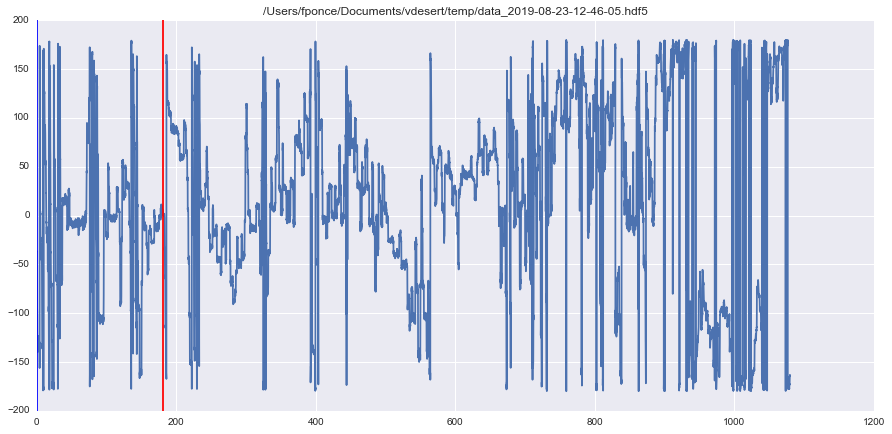

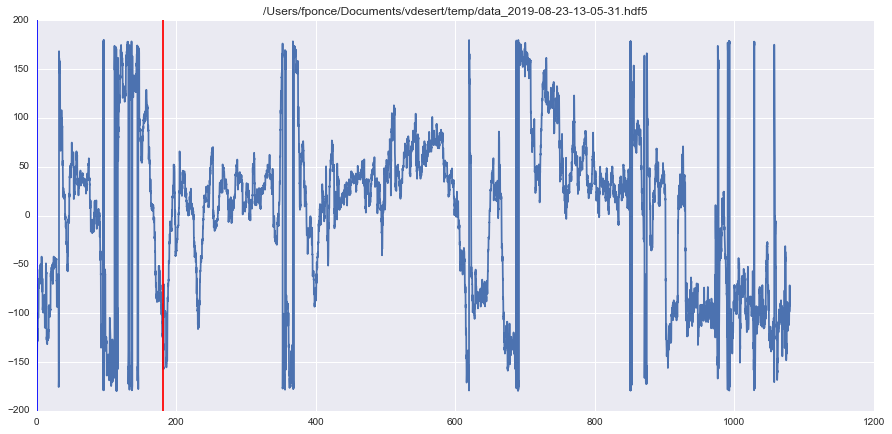

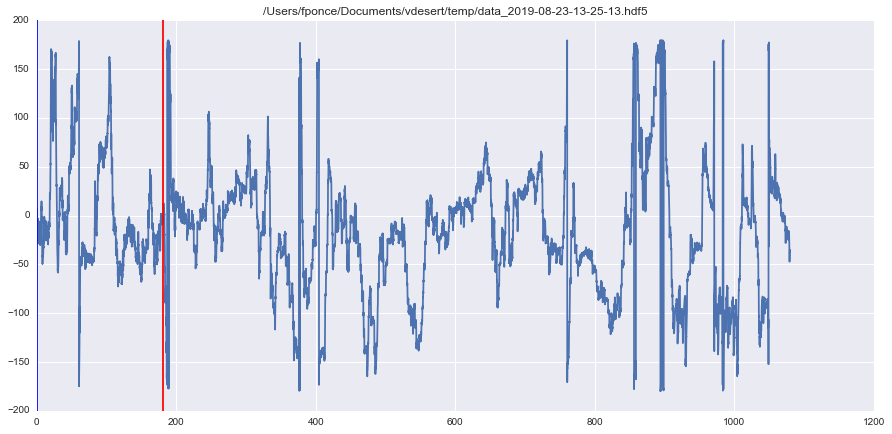

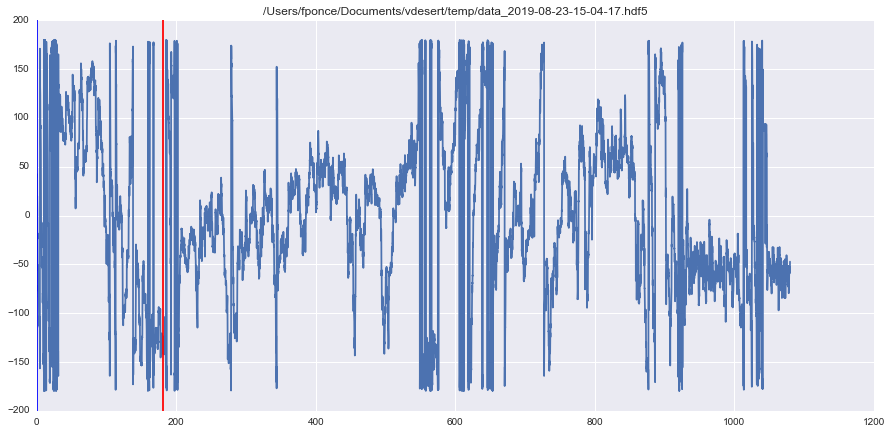

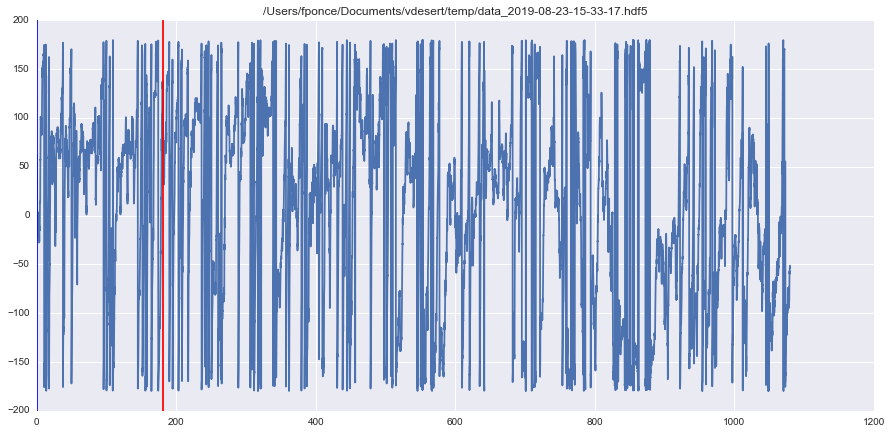

In [151]:
for i in range(len(all_magnotether_angle)):
    plt.figure(figsize = (15, 7))
    plt.plot(reg_t, all_magnotether_interp_angles[i])
    plt.axvline(x = all_start_times_m[i][0])
    plt.axvline(x = all_end_times_m[i][0], color = 'r')
    plt.title(datapaths[i])

In [148]:
# for i in range(len(all_magnotether_angle)):
#     plt.figure()
#     plt.plot(all_magnotether_angle[i])
#     plt.title(datapaths[i])

In [16]:
# #dropping frames
# times = all_magnotether_tstamps

# for i in range(len(times)):
#     plt.figure(figsize = (15,5))
#     plt.scatter(np.arange(0, len(times[i])-1, 1), np.diff(times[i]))
#     #plt.ylim(0,0.2)
#     plt.title('timestamps')
#     frames_dropped = []
#     for j in range(len(np.diff(times[i]))):
#         if (np.diff(times[i]))[j]>0.06:
#             frames_dropped.append(i)
#             #print((np.diff(times[i]))[j])
#     print('percent dropped')
#     print(len(frames_dropped)*100/len(times[i]))

# times = all_magnotether_ros_tstamps

# for i in range(len(times)):
#     plt.figure(figsize = (15,5))
#     plt.scatter(np.arange(0, len(times[i])-1, 1), np.diff(times[i]))
#     #plt.ylim(0,0.2)
#     #plt.xlim(0,500)
#     plt.title('ros timestamps')
#     frames_dropped = []
#     for j in range(len(np.diff(times[i]))):
#         if (np.diff(times[i]))[j]>0.06:
#             frames_dropped.append(i)
#             #print((np.diff(times[i]))[j])
#     print('percent dropped')
#     print(len(frames_dropped))
#     print(len(frames_dropped)*100/len(times[i]))    

In [18]:
#get which patterns where presented
number_trials = 7
#Get panel angle from init angle
all_init_angle_pats = []
for i in range(len(datapaths)):
    ang_panel_pattern_trials = []
    for j in range((number_trials)):
        ang_panel_pattern = all_init_angle[i][np.where(all_trial_index[i]==j)][0]
        ang_panel_pattern_trials.append(ang_panel_pattern)
    all_init_angle_pats.append(ang_panel_pattern_trials)

all_pats = []
for i in range(len(datapaths)):
    pats_trials = []
    for j in [1,2,3,4]:
        if -180<=all_init_angle_pats[i][j]<=-90:
            p=90
        elif -90<=all_init_angle_pats[i][j]<=0:
            p=180
        elif 0<=all_init_angle_pats[i][j]<=90:
            p=-90
        elif 90<=all_init_angle_pats[i][j]<=180:
            p=0
        pats_trials.append(p)
    all_pats.append(pats_trials)
print(all_pats)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [56]:
# i = 0
# j= 0
# plt.figure()
# ang = allangles[i][all_start_frames_m[i][j]:all_end_frames_m[i][j]]
# times = alltimes[i][all_start_frames_m[i][j]:all_end_frames_m[i][j]]
# plt.plot(times, ang)

# i = 0
# j= 1
# plt.figure()
# ang = allangles[i][all_start_frames_m[i][j]:all_end_frames_m[i][j]]
# times = alltimes[i][all_start_frames_m[i][j]:all_end_frames_m[i][j]]
# plt.plot(times, ang)